In [4]:
!pip install requirements.txt

     |████████████████████████████████| 61kB 3.3MB/s 
  Created wheel for mrcnn: filename=mrcnn-0.2-cp36-none-any.whl size=54932 sha256=a5c849588d409e38fd572aec05636ce2f8f5748eff26f7d586d82f326546aa86
  Stored in directory: /root/.cache/pip/wheels/11/ed/28/e550ddc897c04c336b923eae4eb35c9aae993d20ce39d9cc40
Successfully built mrcnn


In [6]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn.utils import Dataset
from mrcnn import visualize
from os import listdir
from numpy import zeros
from numpy import asarray
import time
from xml.etree import ElementTree

Using TensorFlow backend.


In [0]:
class MyMaskRCNNConfig(Config):
    NAME = "MaskRCNN_config"
 
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # number of classes + BG
    NUM_CLASSES = 2+1
   
    STEPS_PER_EPOCH = 238
    
    LEARNING_RATE=0.0005
    
    DETECTION_MIN_CONFIDENCE = 0.9
    
    MAX_GT_INSTANCES=10

In [0]:
config= MyMaskRCNNConfig()

In [77]:
print("Loading Mask R-CNN model...")
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./')

Loading Mask R-CNN model...


In [7]:
model.load_weights('mask_rcnn_coco.h5',by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])


In [0]:
class BlurAndScratchDataset(Dataset):
    def load_dataset(self, dataset_dir, is_train=True):

        self.add_class("dataset", 1, "blur")
        self.add_class("dataset", 2, "scratch")

        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        for filename in listdir(images_dir):

            image_id = filename[:-4]
            # after 120 if we are building the train set
            new_image_id = 0
            if image_id[0:4] == 'blur':
                new_image_id = image_id[4:]
            elif image_id[0:7] == 'scratch':
                new_image_id = image_id[7:]

            if is_train and int(new_image_id) >= 120:
                continue
            # before 120 if we are building the test/val set
            if not is_train and int(new_image_id) < 120:
                continue

            img_path = images_dir + filename

            ann_path = annotations_dir + image_id + '.xml'

            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    def extract_boxes(self, filename):

        tree = ElementTree.parse(filename)
        root = tree.getroot()
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def load_mask(self, image_id):
        info = self.image_info[image_id]

        path = info['annotation']

        boxes, w, h = self.extract_boxes(path)

        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            if info['id'][0:4] == 'blur':
                class_ids.append(self.class_names.index('blur'))
            elif info['id'][0:7] == 'scratch':
                class_ids.append(self.class_names.index('scratch'))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

In [79]:
train_set = BlurAndScratchDataset()
train_set.load_dataset('blur_and_scratch_dataset', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

test_set = BlurAndScratchDataset()
test_set.load_dataset('blur_and_scratch_dataset', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 238
Test: 50


In [10]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=10, layers='heads')
history = model.keras_model.history.history


Starting at epoch 0. LR=0.0005

Checkpoint Path: ./maskrcnn_config20191221T1026/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4  

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/10
238/238 [==============================] - 154s 649ms/step - loss: 1.9821 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.5818 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.6356 - mrcnn_mask_loss: 0.6329 - val_loss: 1.6719 - val_rpn_class_loss: 0.0108 - val_rpn_bbox_loss: 0.3362 - val_mrcnn_class_loss: 0.0688 - val_mrcnn_bbox_loss: 0.5825 - val_mrcnn_mask_loss: 0.6736

Epoch 2/10
238/238 [==============================] - 103s 434ms/step - loss: 1.4514 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2934 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.4638 - mrcnn_mask_loss: 0.6425 - val_loss: 1.3399 - val_rpn_class_loss: 0.0098 - val_rpn_bbox_loss: 0.3383 - val_mrcnn_class_loss: 0.0262 - val_mrcnn_bbox_loss: 0.4335 - val_mrcnn_mask_loss: 0.5321
Epoch 3/10
238/238 [==============================] - 81s 341ms/step - loss: 1.1771 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2212 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.2798 - mrcnn_mask_loss: 0.6344 - val_loss: 1.2028 - val_

In [0]:
model_path = 'mask_rcnn_'  + '.' + str(time.time()) + '.h5'
model.keras_model.save_weights(model_path)

In [0]:
model_path = 'mask_rcnn_.1576924943.852383.h5'

In [0]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
config = MyMaskRCNNConfig()
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')
model.load_weights(model_path, by_name=True)

{'id': 'blur124', 'source': 'dataset', 'path': '/content/drive/My Drive/AIWorks/mrcnn_works/blur_and_scratch_dataset/images/blur124.jpg', 'annotation': '/content/drive/My Drive/AIWorks/mrcnn_works/blur_and_scratch_dataset/annots/blur124.xml'}
image ID: dataset.blur124 (5) /content/drive/My Drive/AIWorks/mrcnn_works/blur_and_scratch_dataset/images/blur124.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  231.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  127.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


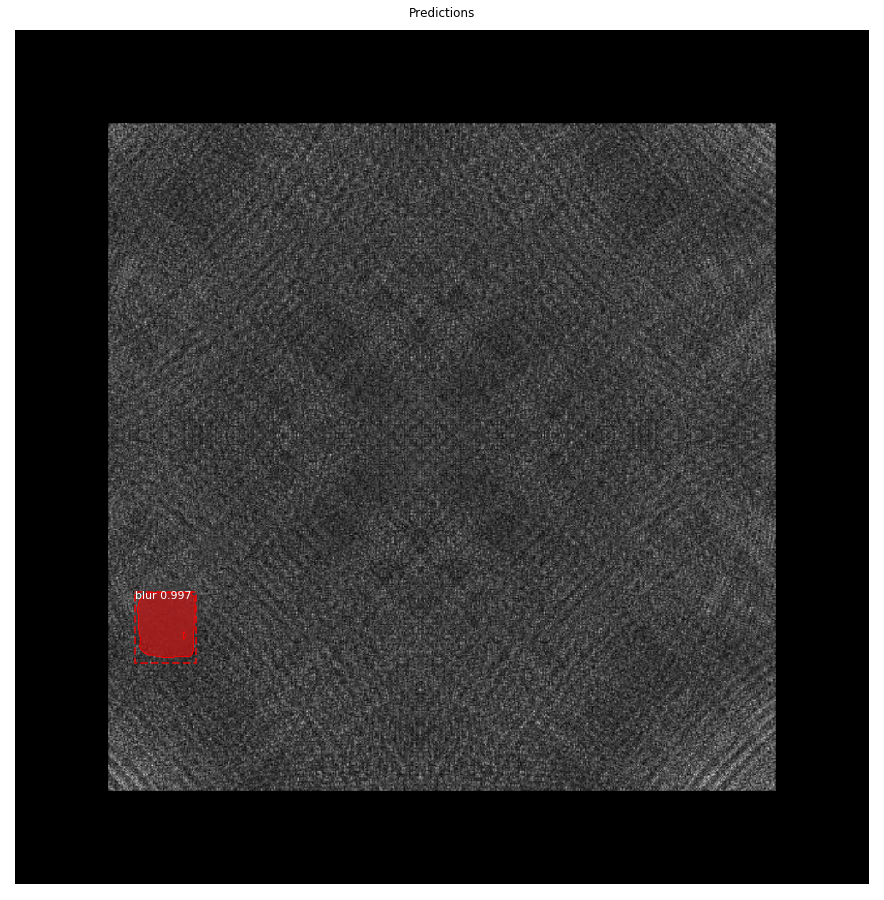

In [107]:
image_id = 5
image, image_meta, gt_class_id, gt_bbox, gt_mask =    modellib.load_image_gt(test_set, config, image_id, use_mini_mask=False)
info = test_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       test_set.image_reference(image_id)))

results = model.detect([image], verbose=1)

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'],
                            title="Predictions")